# Classical Atari 7800/NES ROM Classifier
- ROM file bytes converted to images directly
- Classification using a finetuned resnet

In [1]:
!pip install -Uqq fastai numpy-hilbert-curve internetarchive

In [2]:
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
import math
from hilbert import decode, encode

In [ ]:
!ia download nes-roms --glob="*.nes"
!ia download atari-7800-roms-ultra --glob="*.a78"

In [6]:
def rom2image(path):
    with path.open('rb') as f:
        test_bytes = bytearray(f.read())  # read bytes
        while len(test_bytes) % 3 != 0:  # pad all values to be "whole" pixels
            test_bytes.append(0)
        pix_num = len(test_bytes) // 3
        square = math.ceil(math.sqrt(pix_num))  # round up to nearest square
        test_bytes2 = bytes(test_bytes) + b'\x00\x00\x00' * (square ** 2 - pix_num)  # pad to make square

        return Image.frombytes('RGB', (square, square), test_bytes2)

In [7]:
mldata = Path('classical-nes-or-atari')

nes = Path('nes-roms')
(mldata/'nes').mkdir(exist_ok=True, parents=True)
for i, game in enumerate(nes.glob('*.nes')):
    out_path = mldata/'nes'/f'{i}.png'
    if not out_path.exists():
        rom2image(game).save(out_path)

atari = Path('atari-7800-roms-ultra')
(mldata/'atari').mkdir(exist_ok=True, parents=True)
for i, game in enumerate(atari.glob('*.a78')):
    out_path = mldata/'atari'/f'{i}.png'
    if not out_path.exists():
        rom2image(game).save(out_path)

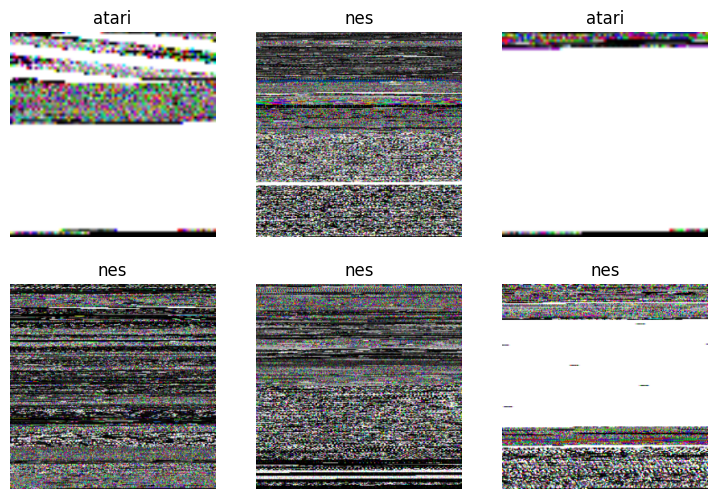

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(mldata, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.544630,0.174833,0.062687,01:42


epoch,train_loss,valid_loss,error_rate,time
0,0.213989,0.082159,0.023881,02:26
1,0.104320,0.062739,0.023881,02:25
2,0.068666,0.070066,0.011940,02:27
3,0.038950,0.051889,0.017910,02:28
4,0.025081,0.061641,0.017910,02:28
5,0.012023,0.061984,0.020896,02:29
